In [2]:
import geopandas as gpd
import geoplot as gplt
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.legend import Legend
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar

import mapclassify as mc
import math

from handlers import TextLegendHandler
from helper_scripts import utils

# set up a handler for text legends
Legend.update_default_handler_map({str: TextLegendHandler.TextHandler()})

# update default font
plt.rcParams["font.family"] = "Frutiger Light Condensed"

### helper functions

In [40]:
def preprocess_data(data: pd.DataFrame, post: str, party: str) -> pd.DataFrame:
    """
    Preprocesses the data and aggregates it by party and wards
    for the specific post and the specific party

    Args:
        post (str): the post in contention
        party (str): the political party in contention
    """
    preprocessed_data = data[(data["contested_post"] == post)]
    preprocessed_data = preprocessed_data[["party", "palika", "ward", "votes"]]

    preprocessed_data = (
        preprocessed_data.groupby(["party", "palika", "ward"]).sum().reset_index()
    )

    preprocessed_data["% of ward votes"] = (
        preprocessed_data["votes"]
        / preprocessed_data.groupby(["palika", "ward"])["votes"].transform("sum")
        * 100
    )

    preprocessed_data = preprocessed_data[preprocessed_data["party"] == party]

    return preprocessed_data

def prepare_axes(figsize):
    """
    prepares the axes and subplots that are used in the figure
    returns the figure, and a list of axes objects
    """
    fig = plt.figure(figsize=figsize)
    # add axes for main map plots, the party selected, and the other top 3 candidates   
    axes = [fig.add_subplot(2,3,2)]
    axes.append(fig.add_subplot(2,3,3))
    axes.append(fig.add_subplot(2,3,5))
    axes.append(fig.add_subplot(2,3,6))
        
    # this plot will show a map of the district, with the map of the region number highlighted
    axes.append(fig.add_subplot(4,3,1))
    
    # set the axes bboxes off
    for ax in axes:
        ax.set_axis_off()
        
    return fig, axes

### Import raw data

In [41]:
elec_data = pd.read_csv("../../data/election_data/ward_votes_all.csv")
map_data = gpd.read_file("../../data/nepal_map_data/nepal-wards.topojson")
ward_constituency_map_data = pd.read_csv(
    "../../data/nepal_map_data/ktm-constituencies.csv"
)[["palika", "ward", "representative_constituency", "provincial_constituency"]]

### Transform the data to select Kathmandu and correct constituencies for Kathmandu in elec_data

In [42]:
district = 'kathmandu'

wards_data_ktm = map_data.query(f'DISTRICT.str.contains("{district.upper()}")', engine="python")
elec_data_ktm = elec_data.query(f'district.str.contains("{district.lower()}")', engine="python")

constituency_clean_data = ward_constituency_map_data.fillna(0)
constituency_clean_data["ward"] = pd.to_numeric(
    constituency_clean_data["ward"], downcast="integer"
)
merged_elec_data_ktm = pd.merge(
    elec_data_ktm,
    constituency_clean_data,
    how="inner",
    on=["ward", "palika"],
    suffixes=("_l", "_r"),
)
clean_elec_data_ktm = merged_elec_data_ktm[
    merged_elec_data_ktm["provincial_constituency_r"] != 0
]

### Prepping for the plotting

/tmp/ipykernel_10659/1957237684.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regional_elec_data_ktm["palika"] = regional_elec_data_ktm["palika"].transform(
/tmp/ipykernel_10659/1957237684.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regional_elec_data_ktm["palika"] = regional_elec_data_ktm["palika"].transform(
/tmp/ipykernel_10659/1957237684.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

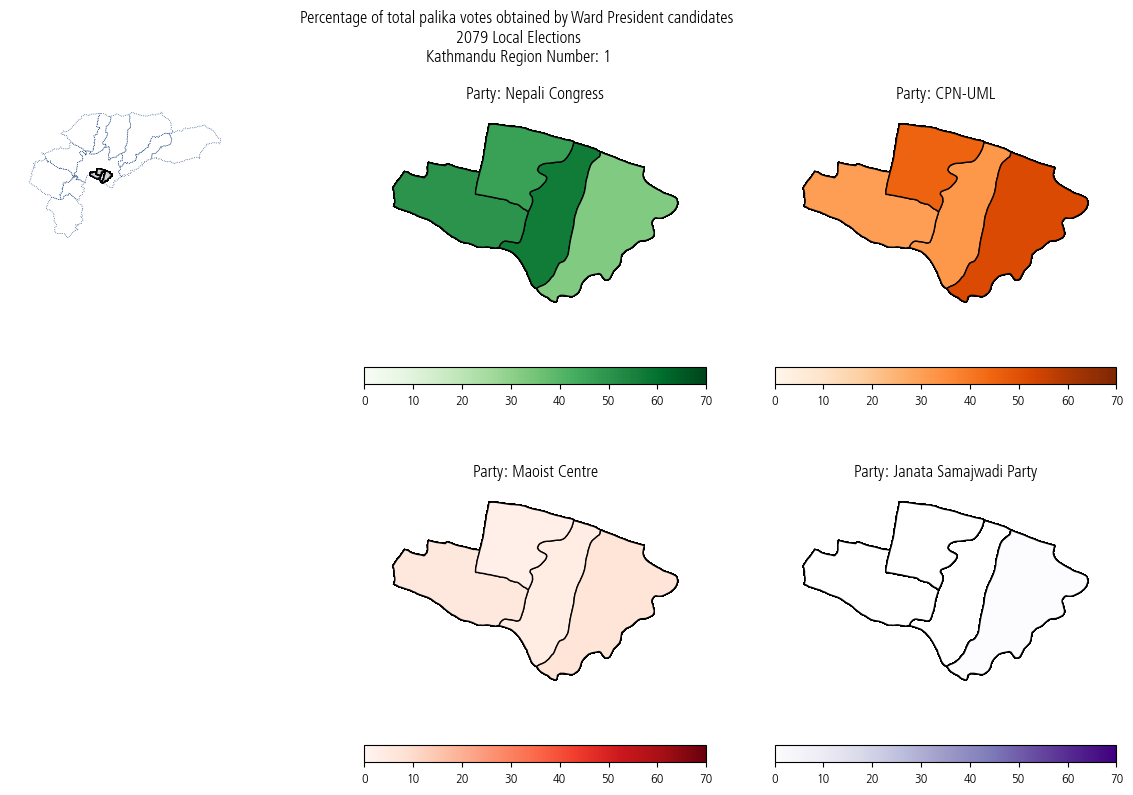

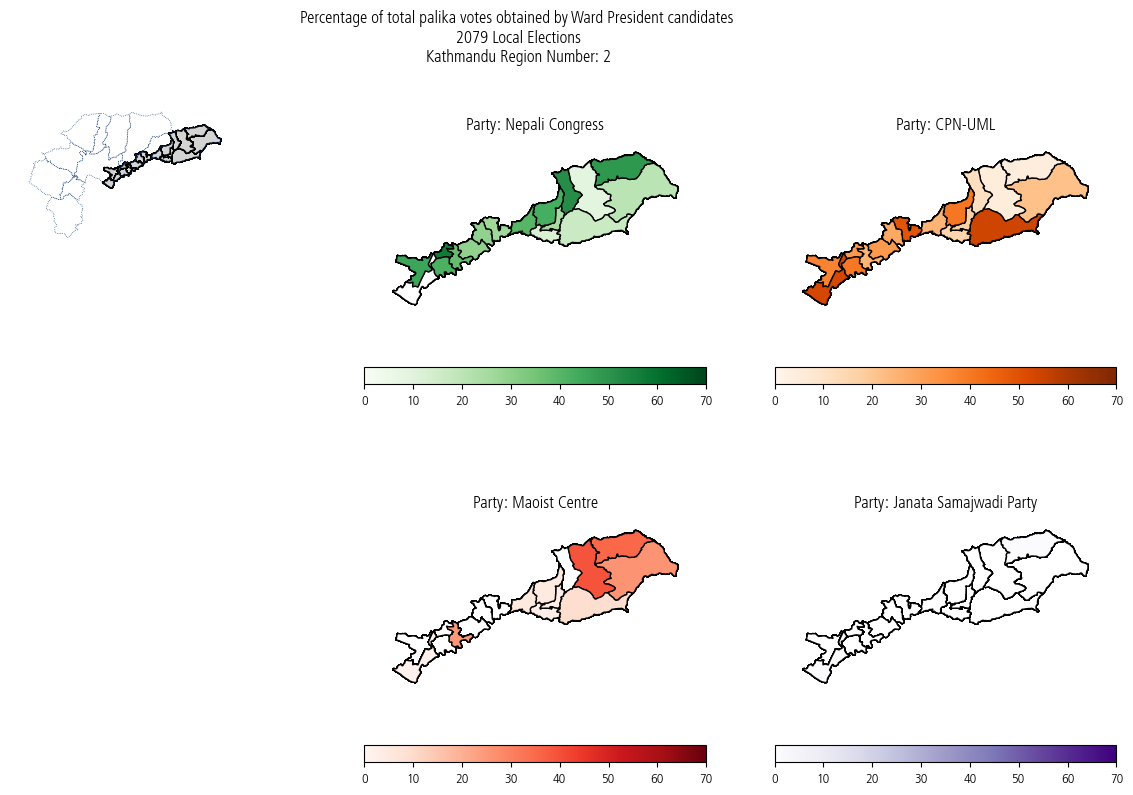

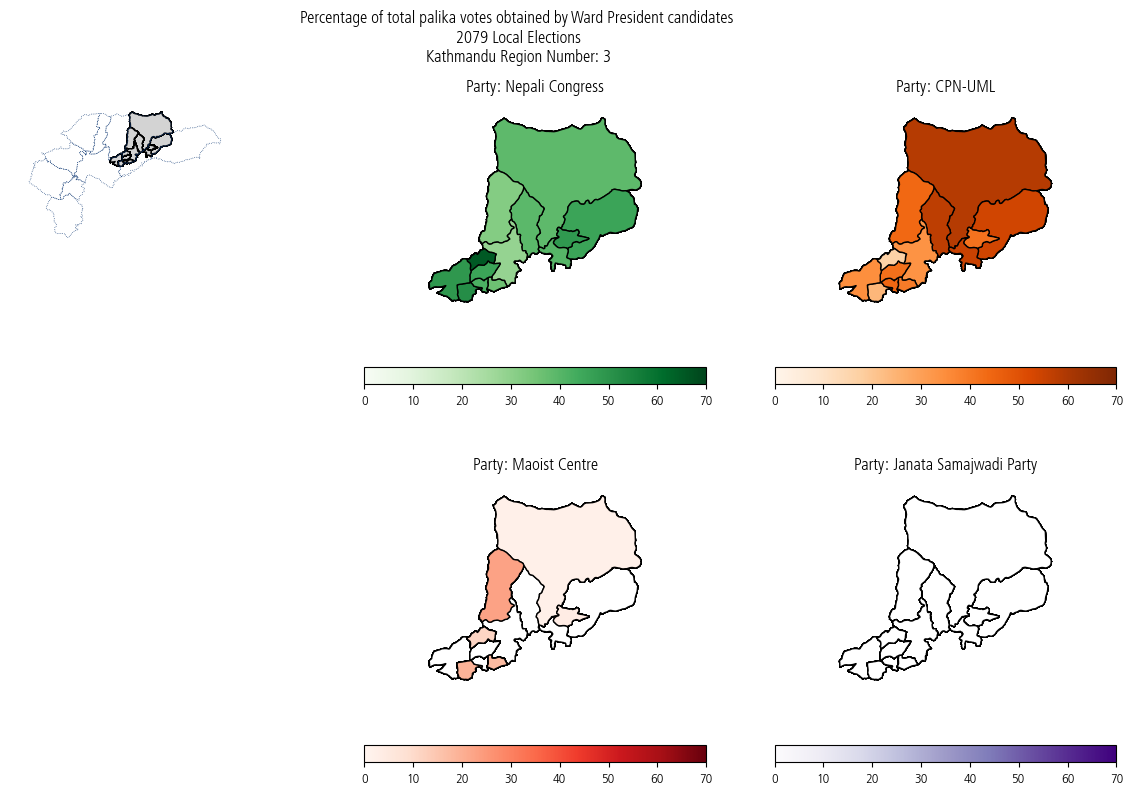

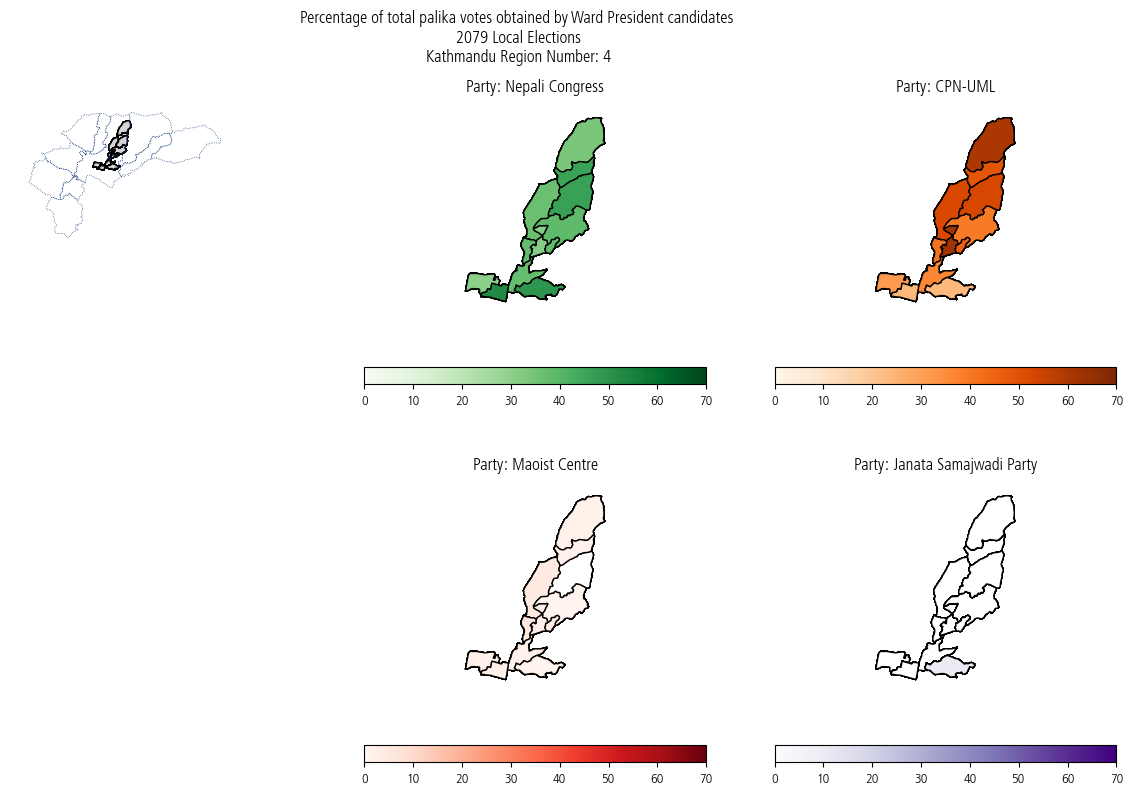

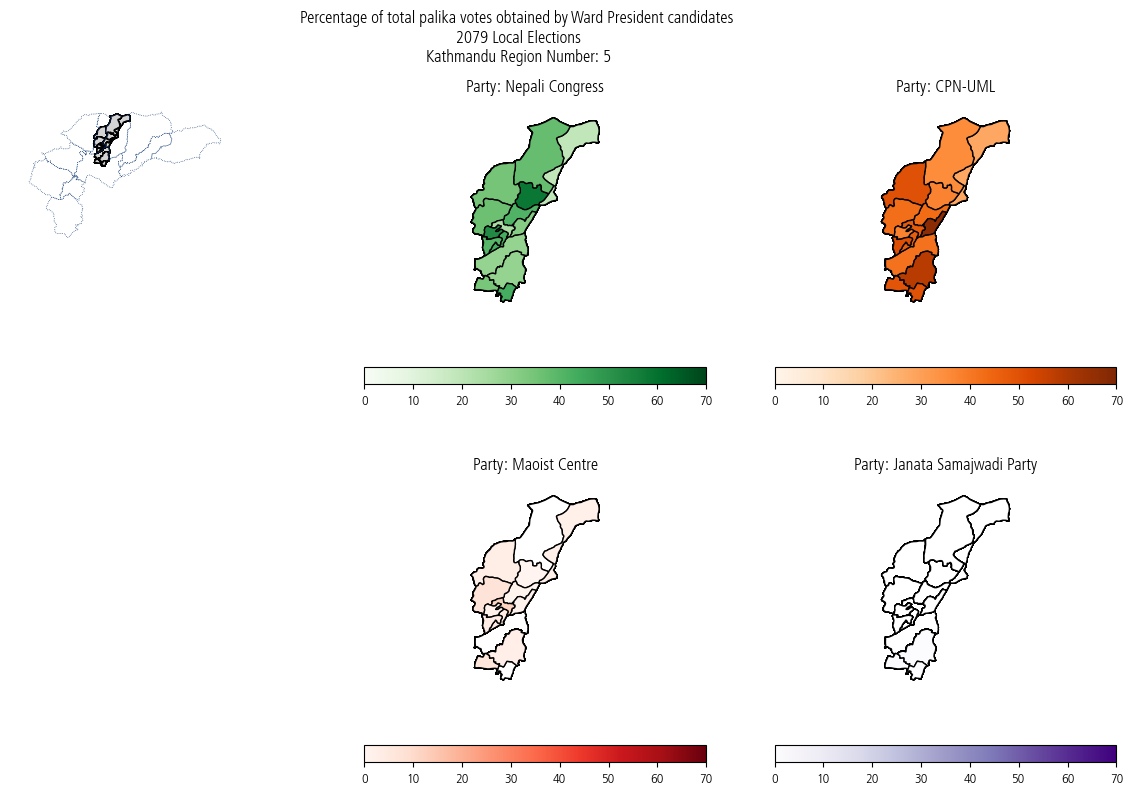

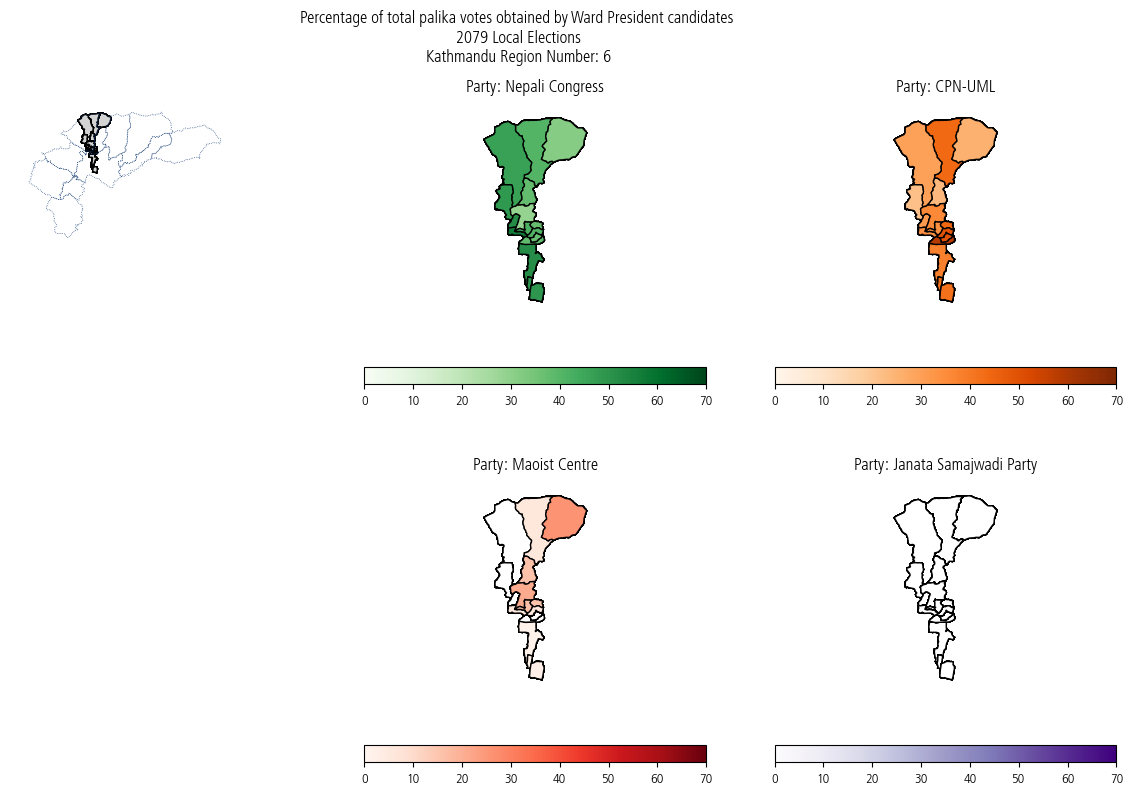

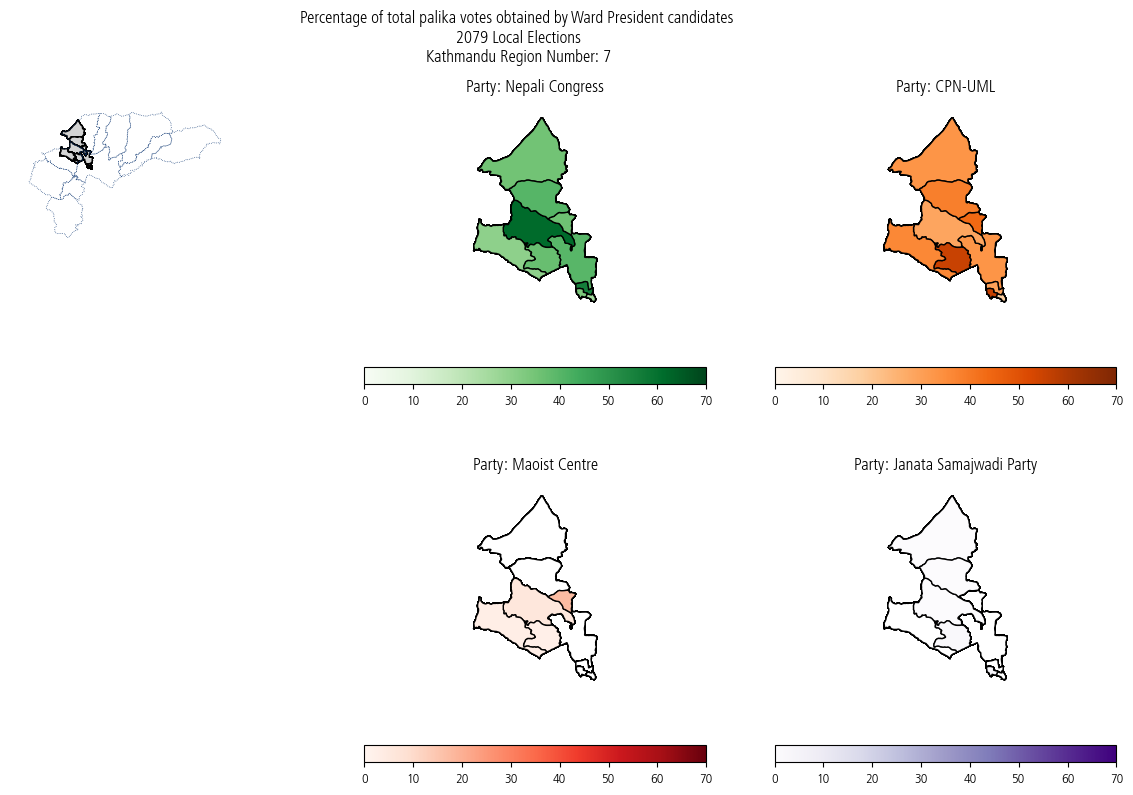

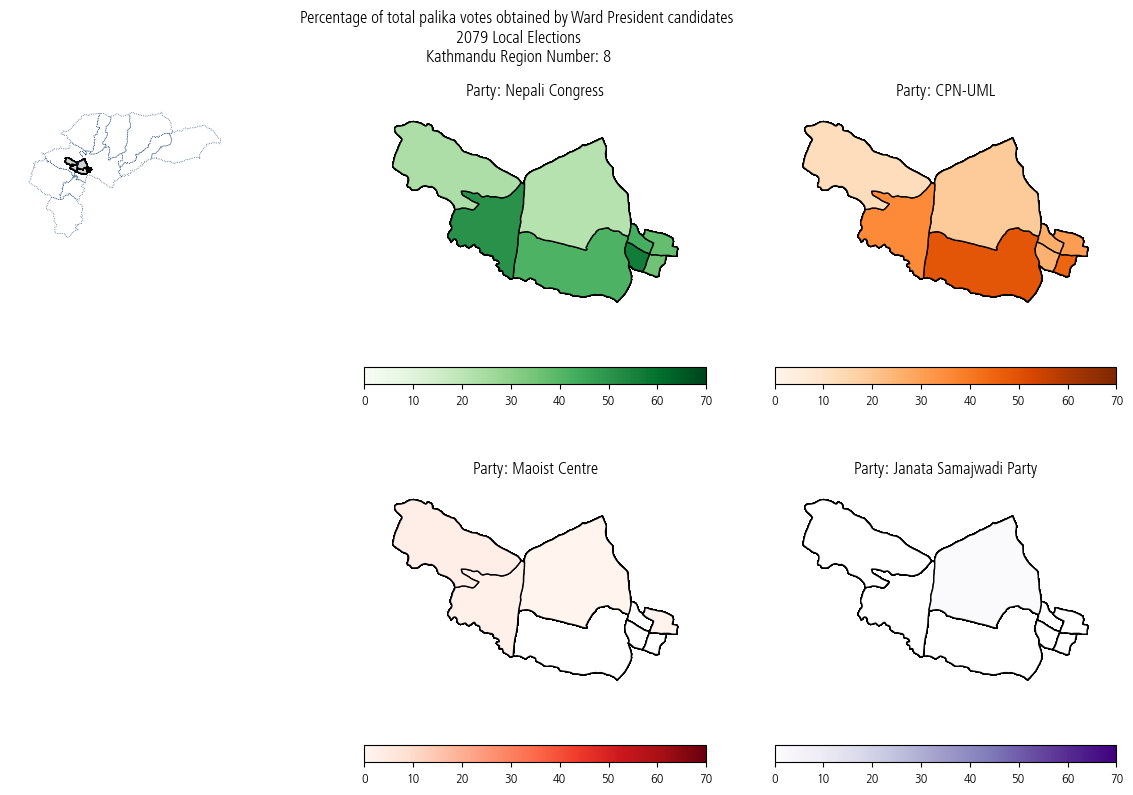

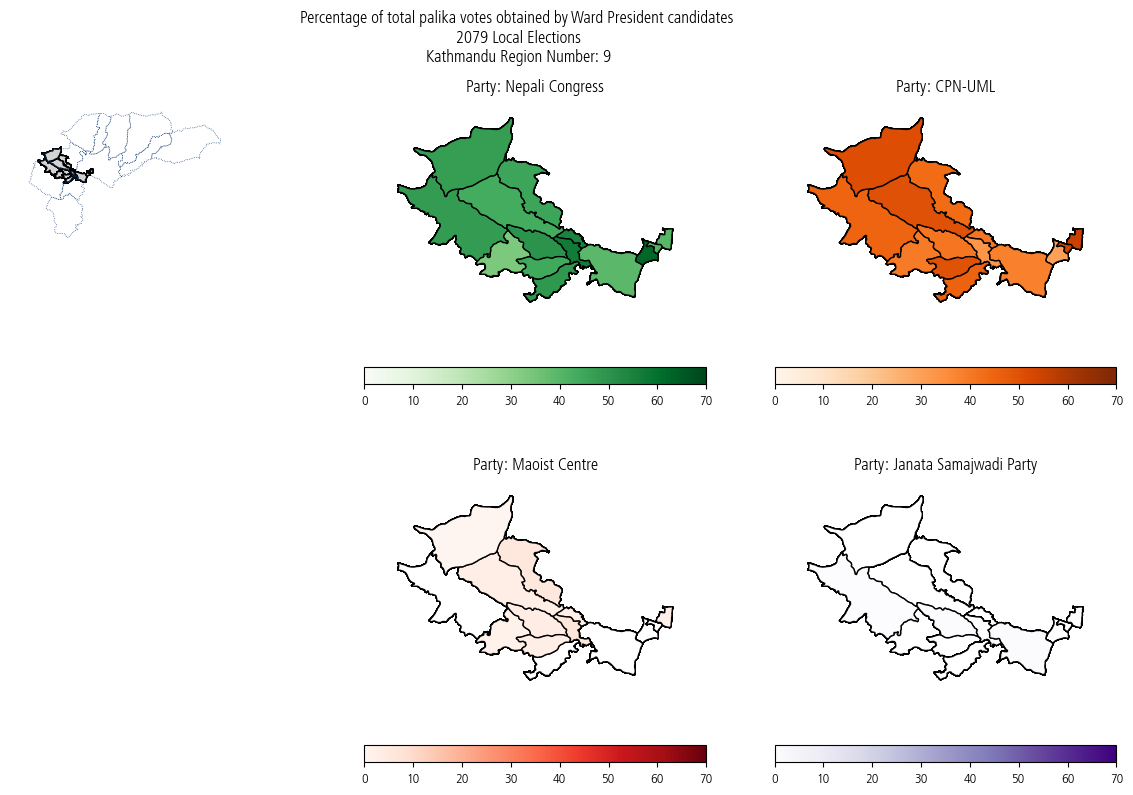

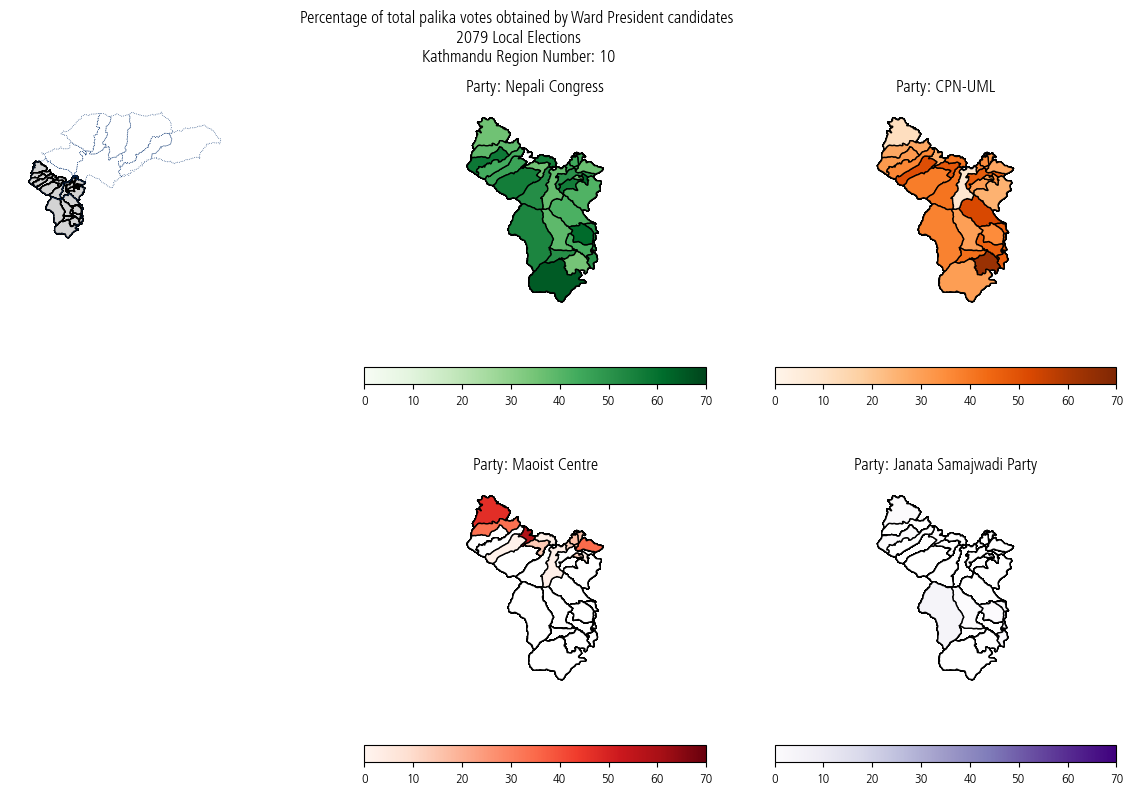

In [45]:
regions = sorted(clean_elec_data_ktm['representative_constituency_r'].unique())
norm = matplotlib.colors.Normalize(vmin=0, vmax=70)

# TODO will need to be dynamic
parties_map = {
    "Nepali Congress": "Greens",
    "CPN-UML": "Oranges",
    "Maoist Centre": "Reds",
    "Janata Samajwadi Party": "Purples",
}

# a non colored map of the selected region, only the ward borders

for region in regions:
    regional_elec_data_ktm = clean_elec_data_ktm[
        clean_elec_data_ktm["representative_constituency_r"] == region
    ]
    regional_elec_data_ktm["palika"] = regional_elec_data_ktm["palika"].transform(
        lambda x: utils.transform_to_capitalized_case(x, "-")
    )

    # a non colored map of the selected region, only the ward borders
    skeleton_region_data_ktm = gpd.GeoDataFrame(
        regional_elec_data_ktm.merge(
            wards_data_ktm,
            how="inner",
            left_on=["palika", "ward"],
            right_on=["PALIKA", "WARD"],
        )
    )
    
    fig, axes = prepare_axes((15,9))
    
    gplt.polyplot(
        skeleton_region_data_ktm,
        facecolor="lightgray",
        ax=axes[-1],
    )

    gplt.polyplot(
        wards_data_ktm.copy().dissolve(by=["PALIKA"]),
        ax=axes[-1],
        linestyle=":",
        edgecolor="#083370",
        linewidth=0.5,
    )
    
    for idx, (party, pallete) in enumerate(parties_map.items()):
        final_data = gpd.GeoDataFrame(
            preprocess_data(regional_elec_data_ktm, "Ward President", party).merge(
                wards_data_ktm,
                how="inner",
                left_on=["palika", "ward"],
                right_on=["PALIKA", "WARD"],
            )
        )

        cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap=pallete).cmap

        gplt.choropleth(
            final_data,
            hue="% of ward votes",
            cmap=cmap,
            norm=norm,
            legend=True,
            legend_kwargs={"orientation": "horizontal"},
            ax=axes[idx],
        )

        gplt.polyplot(
            skeleton_region_data_ktm,
            facecolor="white",
            ax=axes[idx],
        )
        axes[idx].set_title(
            f"Party: {party}"
        )
    fig.suptitle(f'Percentage of total palika votes obtained by Ward President candidates\n 2079 Local Elections\n {district.capitalize()} Region Number: {region}')